In [1]:
%matplotlib inline

from __future__ import division, print_function

import glob as glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import optimize

sns.set_style('white')

/Users/julialeonard/anaconda/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.0.1 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Set parameters

In [2]:
N_samples = 10000
threshold = .5 
REWARD = 1

#_results_index = [
#    'High Effort Success', 'Low Effort Success', 'High Effort Failure', 
#    'Low Effort Failure', 'Baseline'
#]

#human_means = [pd.Series([107, 57, 30, 35,86], index=_results_index),
#               pd.Series([96, 87, 38, 39,59], index=_results_index),
#               pd.Series([171, 94, 62, 45,81], index=_results_index)]

### Free parameters to fit

In [3]:
#COST = 0.5
#B=6
#A=60 
#u_skill = .625 #mean of beta
#tao_skill = 20 #variance of beta
#skill=.4
#scale = 200


### Functions

In [9]:
def prob_reward(e,diff,skill, A, B):
    """Return the probability of getting the reward
    
    Parameters
    ----------
    e : numeric or array-like
        Description of this parameter.
    # TODO: list other parameters
    
    Returns
    -------
    ...
    """
    return 1/(1 + A * np.exp(-(e * skill / diff) * B)) ##plot for different As (moves function around) and Bs (changes sharpness)


def get_effort_multidim(cost, diff, skill, A, B, reward=1):
    """Similar to `get_effort` but accepts arrays or single values of `diff` 
    and `skill`.

    Parameters
    ----------
    ...

    Returns
    -------
    Ndarray with same shape as `diff` and `skill`.
    """
    es = np.linspace(0, 1, 100)
    es_rank2 = es[np.newaxis, ...]
    
    try:
        diff = diff[..., np.newaxis]
    except TypeError:
        pass
    try:
        skill = skill[..., np.newaxis]
    except TypeError:
        pass
    
    prob = prob_reward(e=es_rank2, diff=diff, skill=skill, A=A, B=B)
    utilities = reward * prob - cost * es_rank2
    return es[utilities.argmax(-1)]


def your_eff_know_skill_opt(n_samples, cost, diff, skill, A, B,reward=1):
    """Model for planning.

    Parameters
    ----------
    n_samples : int
    cost : numeric
    diff : array-like
    skill : numeric
    A : numeric
    B : numeric
    reward : numeric
    
    Returns
    -------
    Ndarray of effort.
    """
    rand_diffs = np.random.choice(diff, size=n_samples)
    return get_effort_multidim(
        cost=cost, diff=rand_diffs, skill=skill, A=A, B=B, reward=reward
    )


def create_priors_opt(n_samples, tao_skill, u_skill, cost, A, B, diff, reward=1, 
                      effort_threshold=0.5):
    """Documentation."""
    # Skill and diff are beta distributions.
    skills = np.random.beta(
        tao_skill * u_skill, (1 - u_skill) * tao_skill, size=n_samples,
    )
    
    efforts = get_effort_multidim(
        cost=cost, skill=skills, diff=diff, A=A, B=B,
    )

    high_effort = efforts > effort_threshold
    success = prob_reward(efforts, diff, skills, A, B) > np.random.random(n_samples)

    return skills,  success, high_effort


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## Plot Utility Functions

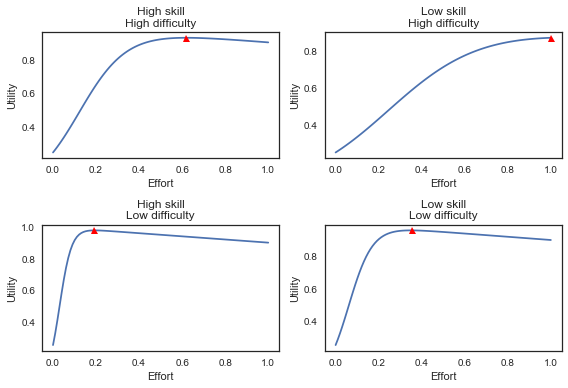

In [15]:
REWARD = 1
COST = .1
skilled = .8
unskilled = .4
hard = .8
easy = .2
A = 3
B = 9
def get_effort(reward, cost, diff, skill):
    Us=list()
    es = np.linspace(0, 1, 100) 
    for i in es:
        U=reward*prob_reward(i, diff, skill, A, B)-cost*i #utility function
        Us.append(U)
    return es[np.argmax(Us)], Us, es  #return argmax of utility, and utilities 

plt.subplot(2,2,1)
effort,Us,es=get_effort(REWARD,COST,hard,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('High skill\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,2)
effort,Us,es=get_effort(REWARD,COST,hard,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('Low skill\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,3)
effort,Us,es=get_effort(REWARD,COST,easy,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('High skill\nLow difficulty')
plt.tight_layout()

plt.subplot(2,2,4)
effort,Us,es=get_effort(REWARD,COST,easy,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('Low skill\nLow difficulty')
plt.tight_layout()

### Function that takes in free parameters and spits out model predictions

In [16]:
def run_model_opt(cost, A, B, u_skill, tao_skill, n_samples=10000):
    np.random.seed(0)
    REWARD=1
    high_diff = .8
    low_diff = .2
    
    high_diff_skills, high_diff_success, high_diff_high_effort = create_priors_opt(
        n_samples =n_samples, tao_skill=tao_skill, u_skill=u_skill, cost=cost, A=A, B=B, diff = high_diff
    )

    low_diff_skills, low_diff_success, low_diff_high_effort = create_priors_opt(
        n_samples =n_samples, tao_skill=tao_skill, u_skill=u_skill, cost=cost, A=A, B=B, diff = low_diff
    )
    

    skill_high_diff_high_eff = high_diff_skills[high_diff_success & high_diff_high_effort]
    skill_high_diff_low_eff = high_diff_skills[high_diff_success & ~high_diff_high_effort]
    skill_low_diff_high_eff = low_diff_skills[low_diff_success & low_diff_high_effort]
    skill_low_diff_low_eff = low_diff_skills[low_diff_success & ~low_diff_high_effort]
    
    print  (np.mean(skill_high_diff_high_eff),np.mean(skill_high_diff_low_eff)) #low num, high num
    print (np.mean(skill_low_diff_high_eff),np.mean(skill_low_diff_low_eff)) #low num, medium num
    
    return model_means

In [18]:
run_model_opt(.2, 2, 9, .5, 1,  n_samples=10000) #play with parameters

#pass functions as parameters

0.436742925647 0.771466745974
0.0987746045277 0.660216731998


NameError: global name 'model_means' is not defined

### Optminize function

In [ ]:
def wrapped_run_model_opt_1(x):
    model_means = run_model_opt(*x)
    loss = rmse(model_means, human_means[0])
    print (loss, x)
    return loss


# key_words=dict(cost = 0.5,B=6,A=60 ,u_skill = .625 ,tao_skill = 20, skill=.4, scale =200)
# rmse_val= run_model_opt(**key_words)

inputs = np.array([0.5, 60, 6, .625, 20, .4, 200])
minimum = optimize.fmin(wrapped_run_model_opt_1, inputs)
minimum

### Optimized parameters

In [ ]:
key_words=dict(cost =  0.40009476,B=6.71213053,A=55.69216106 ,u_skill =  0.70834897,
               tao_skill = 18.78977603, skill=0.41762985, scale =201.32613568)

In [ ]:
model_means= run_model_opt(human_means[0], **key_words)[1]
d = {
    'Model' : pd.Series(model_means, index=_results_index),
    'Human' : human_means[0]
}

df = pd.DataFrame(d)
df